In [54]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn import datasets, decomposition
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Unzip the image dataset

# Just run once

'''
%cd /content
!gdown --id '13shxKy6WSeAa7dPhccnSG9aoFZ76lVPT' --output fairface-img-margin025-trainval.zip
!unzip fairface-img-margin025-trainval.zip

In [2]:
# Download the csv label file for the subset

# Just run once

'''
%cd /content
!gdown --id '1bwKY_aVMRIQ_IcrFnpsTG-E3ZE7iAM8t' --output fairface_subset.csv

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bwKY_aVMRIQ_IcrFnpsTG-E3ZE7iAM8t
To: /content/fairface_subset.csv
100% 279k/279k [00:00<00:00, 105MB/s]


In [5]:
# Load labels
file_path = 'fairface_subset.csv'
labels_df = pd.read_csv(file_path)

labels_df.shape

(6300, 5)

In [6]:
# Preprocess images
def load_and_preprocess_image(image_path):
  # Load image
  image = Image.open(image_path)
  image = image.resize((64, 64))

  # Convert to grayscale
  image = image.convert('L')

  # Convert to numpy array and flatten
  image_array = np.array(image).flatten()
  return image_array


images = [load_and_preprocess_image(f'{fname}') for fname in labels_df['file']]

In [38]:
# Create feature matrix X and labels y
X = np.stack(images, axis=0)
y = labels_df['gender'].values # In the dimension reduction we converted the Male to 0, Female to 1 (to do 3d projection)

In [39]:
# Standardize the Dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dimension Reduction using PCA

In [40]:
# decompose the original feature space into 8 components
pca = decomposition.PCA(n_components=8)
pca.fit(X)
X_pca = pca.transform(X)

In [41]:
pca.explained_variance_ratio_

array([0.33591864, 0.130959  , 0.09966868, 0.04116877, 0.02684666,
       0.02338834, 0.02060111, 0.01832029])

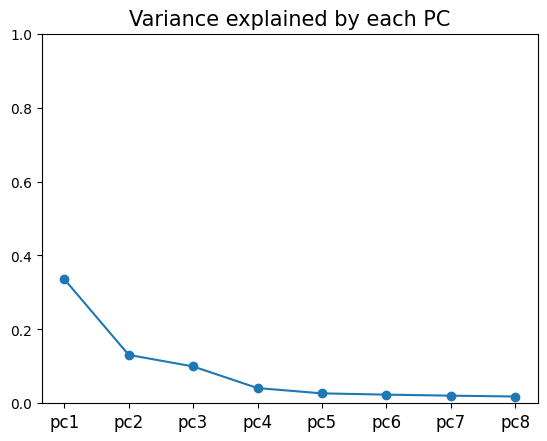

In [42]:
plt.plot(pca.explained_variance_ratio_,'o-')
plt.xticks([0,1,2,3,4,5,6,7],['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8'], fontsize=12)
plt.ylim(0,1)
plt.title('Variance explained by each PC', fontsize=15);

The image dataset is a little more complex and PCA can't work perfectly... But by observing the plot, we can learn that reducting dimension to 5 might be helpful.

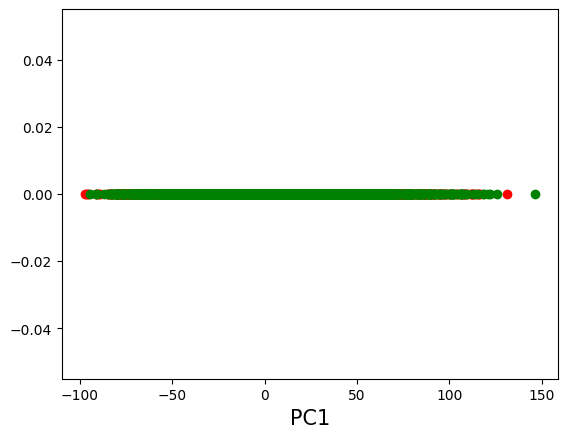

In [43]:
plt.plot(X_pca[:,0][np.where(y=='Male')], np.zeros(len(np.where(y=='Male')[0])), 'o',color='red')
plt.plot(X_pca[:,0][np.where(y=='Female')], np.zeros(len(np.where(y=='Female')[0])), 'o',color='green')

plt.xlabel('PC1', fontsize=15);

It's hard to tell difference from PC1.

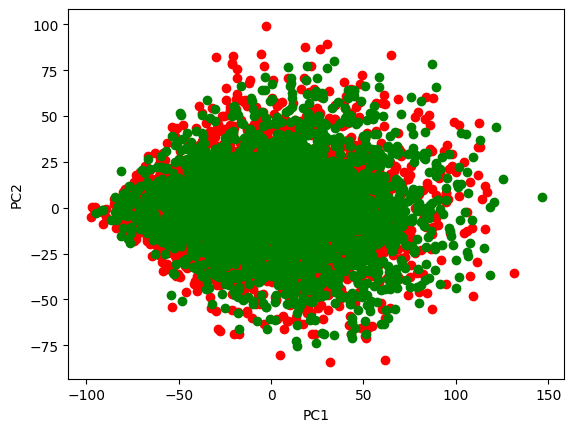

In [44]:
plt.plot(X_pca[:,0][np.where(y=='Male')], X_pca[:,1][np.where(y=='Male')], 'o', color='red')
plt.plot(X_pca[:,0][np.where(y=='Female')], X_pca[:,1][np.where(y=='Female')], 'o', color='green')

plt.xlabel('PC1')
plt.ylabel('PC2');

In [45]:
# Code source: GaÃ«l Varoquaux
# License: BSD 3 clause

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
np.random.seed(5)

In [46]:
# Convert string labels to numeric codes: 0 for Male, 1 for Female
label_to_numeric = {"Male": 0, "Female": 1}
y = np.array([label_to_numeric[item] for item in y])

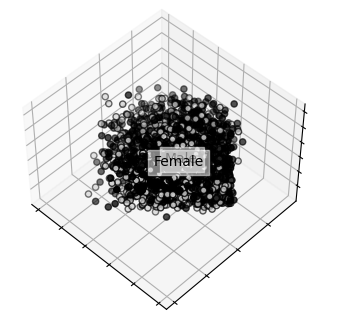

In [47]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

plt.cla()

# Visualize the name of the category
for name, label in [("Male", 0), ("Female", 1)]:
    ax.text3D(
        X_pca[y == label, 0].mean(),
        X_pca[y == label, 1].mean() + 1.5,
        X_pca[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )

# Reorder the labels to have colors matching the cluster results
y_color = np.choose(y, [0, 1]).astype(float)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_color, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

Still a mess :( . But it's obviously better than there's only PC1!

# K-Means

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

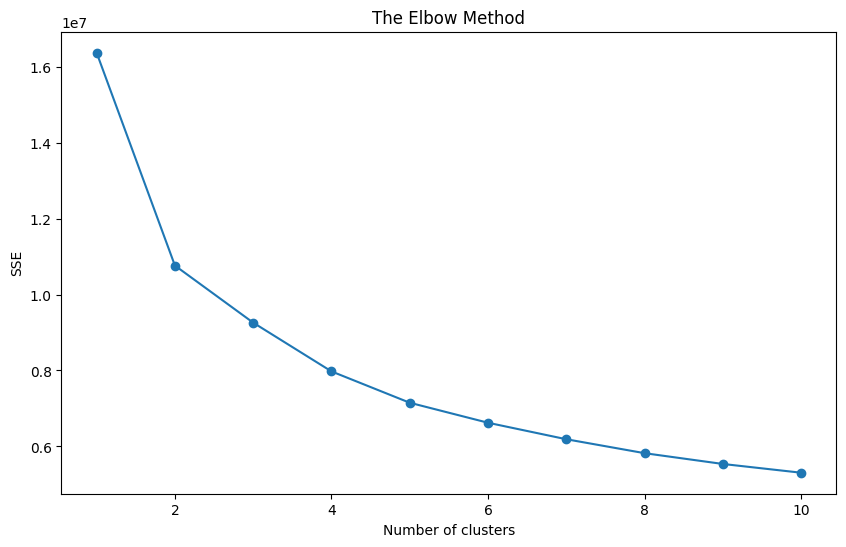

In [61]:
# Apply PCA to reduce to 5 PCs
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Elbow method to determine the optimal number of clusters (k)
sse = []
k_list = range(1, 11)
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

# Plot SSE for each *k*
plt.figure(figsize=(10, 6))
plt.plot(k_list, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method')
plt.show()

 It's a bit challenging to identify a clear 'elbow'. However, there's a slight bend around the cluster number 5. It's not a definitive elbow as seen in some datasets, but based on this plot, 5 could be a reasonable number of clusters to try.

In [57]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
y_pred = kmeans.fit_predict(X_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Still we can try to visualize with the first two PCA.

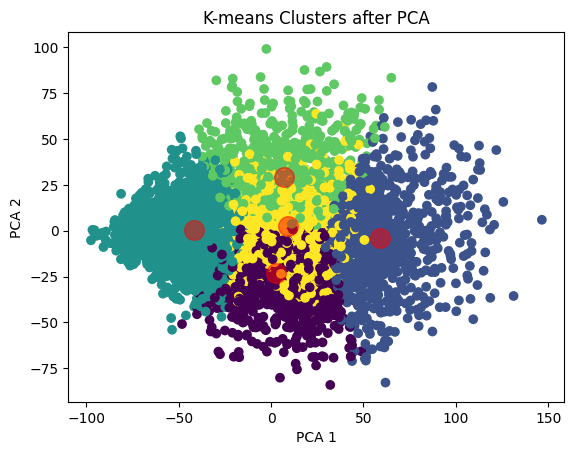

In [58]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-means Clusters after PCA')
plt.show()

In [59]:
# Change the ramdom_state to do a differemt initialization
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


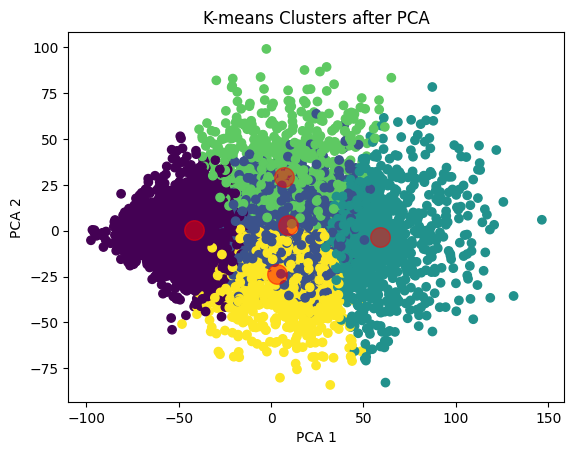

In [60]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-means Clusters after PCA')
plt.show()

There's no clear difference when changing the random state - and not working so well.

# Why the performance is not good?

The curse of dimensionality poses challenges for high-dimensional image datasets, leading to data sparsity and making statistical analysis and model training difficult. Overfitting becomes a significant risk as models may interpret noise as patterns due to many parameters. Traditional distance metrics also become less effective, complicating the use of clustering algorithms.

Dimensionality reduction, like PCA, aims to address these issues by compressing the dataset into a lower-dimensional space while retaining key variance. However, this can sometimes remove critical information necessary for accurate image classification, affecting model performance.

In essence, managing high-dimensional image datasets requires a careful balance between reducing dimensions to alleviate the curse of dimensionality and preserving essential features for accurate task performance.

# Pros and Cons of Each Model

**PCA:**
+ Pros: Reduces dimensionality, mitigating overfitting and reducing computational costs.
+ Cons: Might lose important information if not enough variance is captured by the selected PCs.

**K-Means:**
+ Pros: Simple and efficient for finding clusters in data.
+ Cons: Assumes spherical clusters and is sensitive to the scale of data; may not work well with complex structures like ***images for gender differentiation.***